Parameters: {'n_estimators': 10, 'random_state': 0}, Precision: 0.9416694591402213, Recall: 0.9413878215385271
Parameters: {'n_estimators': 10, 'random_state': 42}, Precision: 0.9416272195028892, Recall: 0.9413675116590049
Empieza entrenamiento con los mejores parametros
Best parameters:  {'n_estimators': 10, 'random_state': 0}


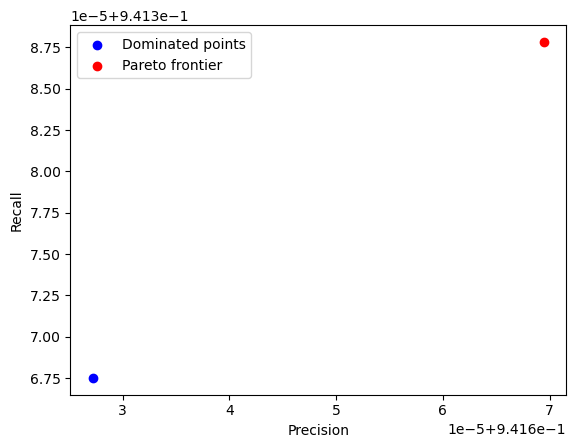

In [1]:
import mnist
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from pareto import is_pareto_optimal
# Cargar los datos de MNIST
X_train, y_train = mnist.train_images(), mnist.train_labels()
X_test, y_test = mnist.test_images(), mnist.test_labels()

# Normalizar las imágenes y aplanarlas para que cada imagen sea un vector de características
X_train = X_train.reshape(X_train.shape[0], -1) / 255.
X_test = X_test.reshape(X_test.shape[0], -1) / 255.

# Definir los parámetros a buscar
param_grid = {'n_estimators': [50,100,150], 'random_state': [0, 42]}

# Crear el objeto ParameterGrid
grid = ParameterGrid(param_grid)

# Crear el objeto KFold
kf = KFold(n_splits=5)

# Inicializar las variables para almacenar los mejores resultados
best_params = None
best_precision = 0
best_recall = 0
mean_precisions = []
mean_recalls = []

# Iterar sobre todas las combinaciones de parámetros
for params in grid:
    # Inicializar las variables para almacenar los resultados de cada iteración de validación cruzada
    precision_scores = []
    recall_scores = []
    
    # Iterar sobre cada iteración de validación cruzada
    for train_index, test_index in kf.split(X_train):
        # Dividir los datos en conjuntos de entrenamiento y prueba
        X_train_cv, X_test_cv = X_train[train_index], X_train[test_index]
        y_train_cv, y_test_cv = y_train[train_index], y_train[test_index]
        
        # Entrenar el modelo con los datos de entrenamiento y los parámetros actuales
        rf_model = RandomForestClassifier(**params)
        rf_model.fit(X_train_cv, y_train_cv)
        
        # Evaluar el modelo en el conjunto de prueba
        y_test_pred = rf_model.predict(X_test_cv)
        
        # Calcular la precisión y la exhaustividad y agregarlas a las listas correspondientes
        precision_scores.append(precision_score(y_test_cv, y_test_pred, average='macro'))
        recall_scores.append(recall_score(y_test_cv, y_test_pred, average='macro'))
    
    # Calcular la precisión y la exhaustividad promedio para esta combinación de parámetros
    mean_precision = np.mean(precision_scores)
    mean_recall = np.mean(recall_scores)
    
    # Add the mean precision and mean recall values to their respective lists
    mean_precisions.append(mean_precision)
    mean_recalls.append(mean_recall)
    
    # Print the mean precision and mean recall values for this configuration
    print(f"Parameters: {params}, Precision: {mean_precision}, Recall: {mean_recall}")
    
    # Si la precisión y la exhaustividad son mejores que las mejores hasta ahora, actualizar las variables correspondientes
    if mean_precision > best_precision and mean_recall > best_recall:
        best_params = params
        best_precision = mean_precision
        best_recall = mean_recall
        
# Convert the lists of mean precision and mean recall values to arrays

mean_precisions = np.array(mean_precisions)
mean_recalls = np.array(mean_recalls) 

# Imprimir los mejores parámetros encontrados
print("Empieza entrenamiento con los mejores parametros")

# Entrenar el modelo con los mejores parámetros encontrados
rf_model = RandomForestClassifier(**best_params)
rf_model.fit(X_train, y_train)

# Imprimir los mejores parámetros encontrados
print("Best parameters: ", best_params)


# Find the non-dominated points (i.e., the points on the Pareto frontier)
evalpareto = is_pareto_optimal(np.column_stack((mean_precisions, mean_recalls)))

# Plot the precision/recall space
plt.scatter(mean_precisions[~evalpareto], mean_recalls[~evalpareto], color='blue', label='Dominated points')
plt.scatter(mean_precisions[evalpareto], mean_recalls[evalpareto], color='red', label='Pareto frontier')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.legend()
plt.show()